In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

pd.set_option("display.max_columns", 100)
sns.set(style="whitegrid")

# Load
df = pd.read_csv("../data/interim/sales_joined_cleaned.csv")

# Force-parse dates (even if dtype is 'object' or 'string')
for col in ["sale_date", "last_purchase_date"]:
    df[col] = pd.to_datetime(df[col], errors="coerce", infer_datetime_format=True)

# Snapshot date for recency
snapshot_date = pd.to_datetime(df["sale_date"].max())

# Customer aggregates
cust = (
    df.groupby("customer_id")
      .agg(
          last_purchase=("last_purchase_date", "max"),
          total_orders=("sale_id", "count"),
          total_revenue=("total_value", "sum"),
          total_quantity=("quantity", "sum"),
          age=("age", "last"),
          gender=("gender", "last"),
          region=("region", "last"),
          churn=("churn", "max"),
          tenure_months=("tenure_months", "last")
      )
      .reset_index()
)

# Ensuring last_purchase is datetime (in case max aggregated strings)
cust["last_purchase"] = pd.to_datetime(cust["last_purchase"], errors="coerce")

# RFM
# Recency in days; filling the missing last_purchase with a large recency
cust["recency"] = (snapshot_date - cust["last_purchase"]).dt.days
cust["recency"] = cust["recency"].fillna(cust["recency"].max() if cust["recency"].notna().any() else 9999).astype("int32")

cust["frequency"] = cust["total_orders"].astype("int32")
cust["monetary"]  = cust["total_revenue"].astype("float64")

print(cust[["customer_id","last_purchase","recency","frequency","monetary"]].head())
print("Rows (customers):", len(cust))

  customer_id last_purchase  recency  frequency  monetary
0   CUST00001    2023-07-18      166          2  187000.0
1   CUST00002    2023-06-27      187          4   84300.0
2   CUST00003    2023-02-06      328          4  130150.0
3   CUST00004    2023-11-28       33          5  302000.0
4   CUST00005    2023-04-05      270          1    8000.0
Rows (customers): 1967


/var/folders/31/f5jzh4490fgd72bczq3kgfzh0000gn/T/ipykernel_1113/15164075.py:19: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df[col] = pd.to_datetime(df[col], errors="coerce", infer_datetime_format=True)
/var/folders/31/f5jzh4490fgd72bczq3kgfzh0000gn/T/ipykernel_1113/15164075.py:19: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df[col] = pd.to_datetime(df[col], errors="coerce", infer_datetime_format=True)


Silhouette scores by k:
k=2: 0.3234
k=3: 0.3134
k=4: 0.2966
k=5: 0.2844
k=6: 0.2711
k=7: 0.2669


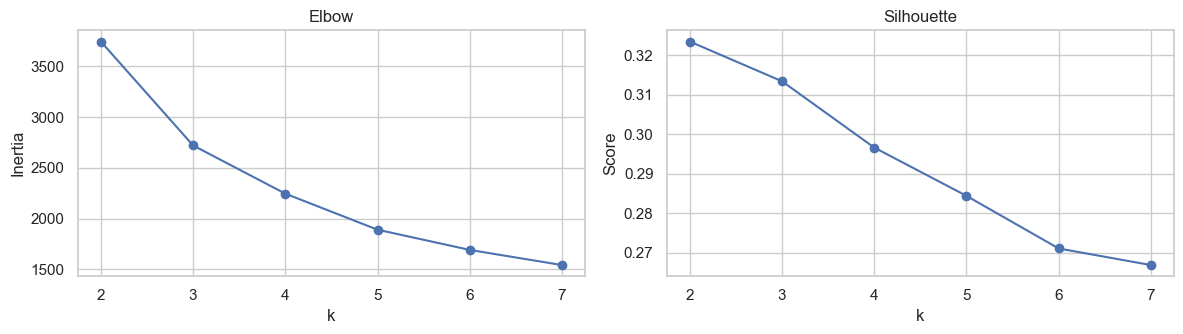

In [11]:
rfm_mat = cust[["recency","frequency","monetary"]].fillna(0).to_numpy()
scaler = StandardScaler()
X = scaler.fit_transform(rfm_mat)

ks = range(2, 8)
inertia, sil = [], []

for k in ks:
    km = KMeans(n_clusters=k, n_init=20, random_state=42)
    labels = km.fit_predict(X)
    inertia.append(km.inertia_)
    sil.append(silhouette_score(X, labels))

print("Silhouette scores by k:")
for k, s in zip(ks, sil):
    print(f"k={k}: {s:.4f}")

fig, ax = plt.subplots(1,2, figsize=(12,3.5))
ax[0].plot(list(ks), inertia, marker="o"); ax[0].set_title("Elbow"); ax[0].set_xlabel("k"); ax[0].set_ylabel("Inertia")
ax[1].plot(list(ks), sil, marker="o");    ax[1].set_title("Silhouette"); ax[1].set_xlabel("k"); ax[1].set_ylabel("Score")
plt.tight_layout(); plt.show()

In [12]:
BEST_K = 2

km = KMeans(n_clusters=BEST_K, n_init=50, random_state=42)
cust["cluster"] = km.fit_predict(X)

# Keep the scaled RFM too (handy for models later)
cust[["recency_scaled","frequency_scaled","monetary_scaled"]] = X

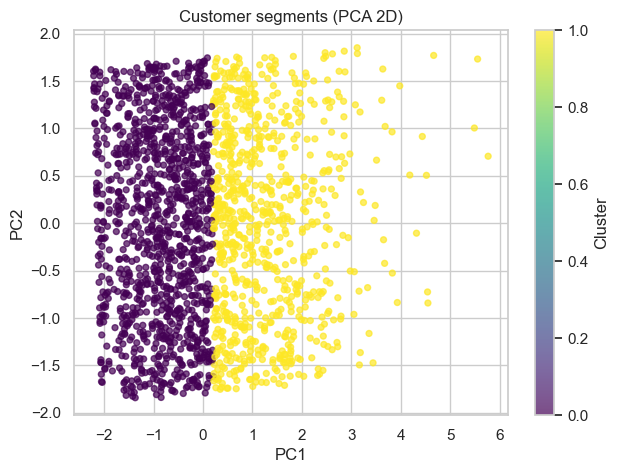

PCA explained variance: [0.55895254 0.33292133]


In [13]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=42)
Z = pca.fit_transform(X)

plt.figure(figsize=(7,5))
plt.scatter(Z[:,0], Z[:,1], c=cust["cluster"], s=18, cmap="viridis", alpha=0.7)
plt.colorbar(label="Cluster")
plt.title("Customer segments (PCA 2D)"); plt.xlabel("PC1"); plt.ylabel("PC2")
plt.show()

print("PCA explained variance:", pca.explained_variance_ratio_)

recency              frequency                monetary                
           mean median count      mean median count       mean    median count
cluster                                                                       
0        188.55  192.0  1171      2.91    3.0  1171  111899.62  103350.0  1171
1        178.78  182.5   796      5.77    6.0   796  324377.14  312050.0   796

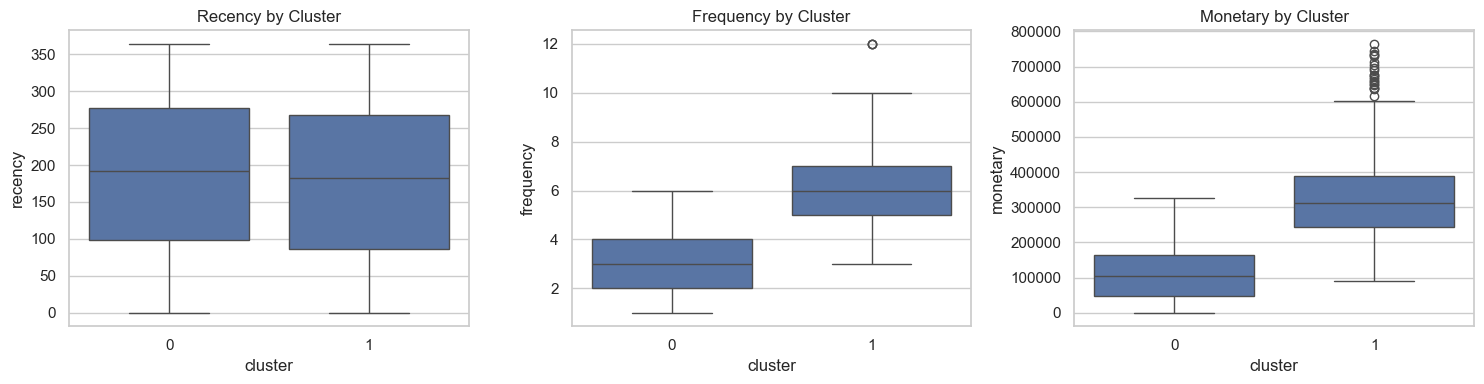

In [14]:
import seaborn as sns

profile = (cust
           .groupby("cluster")[["recency","frequency","monetary"]]
           .agg(["mean","median","count"])
           .round(2))
display(profile)

fig, axes = plt.subplots(1,3, figsize=(15,4))
sns.boxplot(data=cust, x="cluster", y="recency",   ax=axes[0]); axes[0].set_title("Recency by Cluster")
sns.boxplot(data=cust, x="cluster", y="frequency", ax=axes[1]); axes[1].set_title("Frequency by Cluster")
sns.boxplot(data=cust, x="cluster", y="monetary",  ax=axes[2]); axes[2].set_title("Monetary by Cluster")
plt.tight_layout(); plt.show()

In [15]:
# Label by median values
tmp = cust.groupby("cluster")[["recency","frequency","monetary"]].median()
ordering = tmp.sort_values(["monetary","frequency","recency"], ascending=[False, False, True]).index
label_map = {cl: f"Segment {i+1}" for i, cl in enumerate(ordering)}
cust["segment_label"] = cust["cluster"].map(label_map)

cust[["customer_id","cluster","segment_label","recency","frequency","monetary"]].head()

,customer_id,cluster,segment_label,recency,frequency,monetary
0,CUST00001,0,Segment 2,166,2,187000.0
1,CUST00002,0,Segment 2,187,4,84300.0
2,CUST00003,0,Segment 2,328,4,130150.0
3,CUST00004,1,Segment 1,33,5,302000.0
4,CUST00005,0,Segment 2,270,1,8000.0


In [16]:
# 1) RFM features only (for reuse/joins)
rfm_features = cust[["customer_id","recency","frequency","monetary",
                     "recency_scaled","frequency_scaled","monetary_scaled"]]
rfm_features.to_csv("../data/interim/rfm_features.csv", index=False)

# 2) Customer segments (what classification / forecasting can merge on)
segments = cust[["customer_id","cluster","segment_label"]]
segments.to_csv("../data/interim/customer_segments.csv", index=False)

# 3) Full customer master (convenience)
cust.to_csv("../data/interim/rfm_clustered.csv", index=False)

print("Saved: data/interim/rfm_features.csv")
print("Saved: data/interim/customer_segments.csv")
print("Saved: data/interim/rfm_clustered.csv")

Saved: data/interim/rfm_features.csv
Saved: data/interim/customer_segments.csv
Saved: data/interim/rfm_clustered.csv


In [17]:
# --- SAVE: KMeans on scaled RFM (+scaler) and PCA (viz only) ---
import pickle

kmeans_artifacts = {
    "model": km,                                            # fitted KMeans
    "feature_columns": ["recency", "frequency", "monetary"],# training feature order
    "scaler": scaler,                                       # StandardScaler fitted on RFM
    "n_features": int(X.shape[1]),                          # columns KMeans expects (here 3)
    "used_pca": False,                                      # KMeans was NOT fit on PCA
    "pca": pca                                              # kept only for visualization
}

# include your human-friendly labels if you created them
if "label_map" in globals():
    kmeans_artifacts["label_map"] = label_map

with open("../models/kmeans.pkl", "wb") as f:
    pickle.dump(kmeans_artifacts, f)

print("Saved: ../models/kmeans.pkl")

Saved: ../models/kmeans.pkl
